In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

from glash import Glash
tf.random.set_random_seed(42)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
no_samples = 250

test_obj = Glash(no_samples, [no_samples])
test_obj.glash_compile()

batch_size = 10
dataset = [np.random.normal(10, 0.1, no_samples) for i in range(70)]
dataset = test_obj.data_processing(dataset, batch_size)

test_obj.train_glash(dataset, batch_size)
new = np.array([np.random.normal(1, 0.2, no_samples)])
test = test_obj.glash_predict(new)

2021-11-03 15:10:11.897659: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-03 15:10:11.897923: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-03 15:10:11.899323: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2021-11-03 15:10:12.507120: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-11-03 15:10:12.526412: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


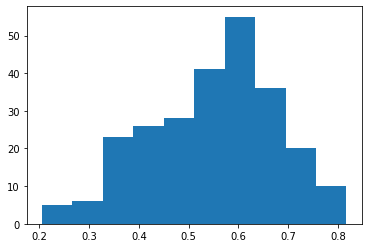

In [3]:
plt.hist(test)
plt.show()

(array([ 3.,  0.,  0.,  1.,  2.,  0.,  3.,  0.,  2.,  3.,  6.,  5.,  1.,
         5.,  5.,  5.,  2.,  6.,  9.,  5.,  6.,  6.,  5.,  4.,  7.,  8.,
        11.,  7.,  7., 11.,  7.,  8.,  6., 15.,  9., 11.,  9.,  6.,  6.,
         7.,  4.,  2.,  4.,  2.,  9.,  3.,  4.,  1.,  0.,  2.]),
 array([0.29185766, 0.3006502 , 0.30944276, 0.3182353 , 0.32702783,
        0.33582038, 0.34461293, 0.35340548, 0.36219802, 0.37099057,
        0.3797831 , 0.38857564, 0.3973682 , 0.40616074, 0.4149533 ,
        0.42374584, 0.43253836, 0.4413309 , 0.45012346, 0.458916  ,
        0.46770856, 0.4765011 , 0.48529363, 0.49408618, 0.5028787 ,
        0.5116713 , 0.5204638 , 0.52925634, 0.5380489 , 0.54684144,
        0.555634  , 0.56442654, 0.57321906, 0.58201164, 0.59080416,
        0.59959674, 0.60838926, 0.61718184, 0.62597436, 0.6347669 ,
        0.64355946, 0.652352  , 0.66114455, 0.6699371 , 0.6787296 ,
        0.6875222 , 0.6963147 , 0.7051073 , 0.7138998 , 0.7226924 ,
        0.7314849 ], dtype=float32),

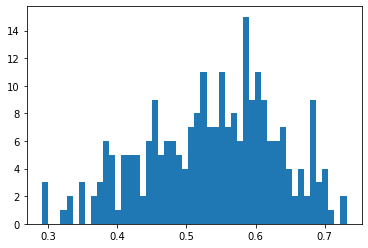

In [4]:
new_2 = np.array([np.random.uniform(1, 0.2, no_samples)])
test_2 = test_obj.glash_predict(new_2)
plt.hist(test_2, bins=50)

(array([ 4.,  7., 23., 26., 34., 41., 55., 32., 22.,  6.]),
 array([0.2288549 , 0.286309  , 0.34376314, 0.40121725, 0.4586714 ,
        0.5161255 , 0.5735796 , 0.6310337 , 0.6884879 , 0.745942  ,
        0.8033961 ], dtype=float32),
 <BarContainer object of 10 artists>)

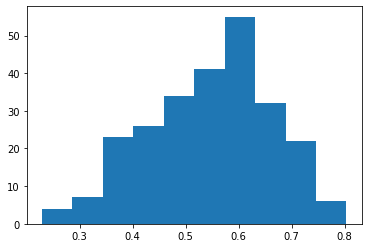

In [5]:
new_3 = np.array([np.random.normal(1, 0.2, no_samples)])
test_3 = test_obj.glash_predict(new_3)
plt.hist(test_3)